# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

For my final project, I try and determine the best **NYC neighborhood** for a **Persian family** to relocate from out of state; given that they want to be in a neigborhood with a high amount of **middle eastern restaurants**. 

Therefor, the target stakeholders I'm interested in are both **Persian families and Middle Eastern families.**

Given that there are a lot of different borough and neighborhoods around NYC, we will be using the Foursquare API to determine which restaurants fall under our interests. We will then group those restaurants by borough and neighborhood to determine the distributions across NYC. Lastly, in order to ensure we locate our Persian family to a location with **good** restaurants, we will also look at the neighborhoods in order of highest rated middle eastern restaurants and most liked. 

In [31]:
!pip install geocoder
!pip install folium

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Data <a name="data"></a>

The variables that this project is interested in are as the following:
1.The count of middle eastern labeled restaurants in NYC.
2.The restaurants from variable one grouped by both neighborhood and borough.
3.The restaurants values for tips, ratings, number of likes.

The variables will be extracted from data retreived from the Foursquare API. 
The geo information for NYC will be retreived from https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON

In [32]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### In the below step, we are cleaning the dataframe

In [33]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = '' # your Foursquare Secret
    VERSION = '20180605' 
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [34]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = '' # your Foursquare Secret
    VERSION = '20180605' 
    

    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [40]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [41]:
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


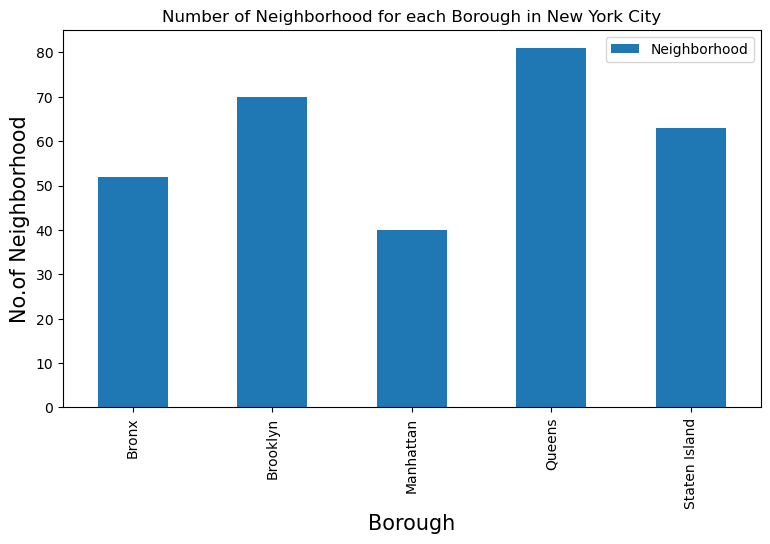

In [42]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [45]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
me_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    me_resturants=venues[venues['Category']=='Middle Eastern Restaurant']   
    print('(',count,'/',len(new_york_data),')','Middle Eastern Resturants in '+Neighborhood+', '+Borough+':'+str(len(me_resturants)))
    for resturant_detail in me_resturants.values.tolist():
        id, name , category=resturant_detail
        me_rest_ny = me_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Middle Eastern Resturants in Wakefield, Bronx:0
( 2 / 306 ) Middle Eastern Resturants in Co-op City, Bronx:0
( 3 / 306 ) Middle Eastern Resturants in Eastchester, Bronx:0
( 4 / 306 ) Middle Eastern Resturants in Fieldston, Bronx:0
( 5 / 306 ) Middle Eastern Resturants in Riverdale, Bronx:0
( 6 / 306 ) Middle Eastern Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Middle Eastern Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Middle Eastern Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Middle Eastern Resturants in Norwood, Bronx:0
( 10 / 306 ) Middle Eastern Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Middle Eastern Resturants in Baychester, Bronx:0
( 12 / 306 ) Middle Eastern Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Middle Eastern Resturants in City Island, Bronx:0
( 14 / 306 ) Middle Eastern Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Middle Eastern Resturants in University Heights, Bronx:0
( 16 / 306 ) Middle Eastern Resturants in Morris Heights, Bro

In [46]:
me_rest_ny.shape

(78, 4)

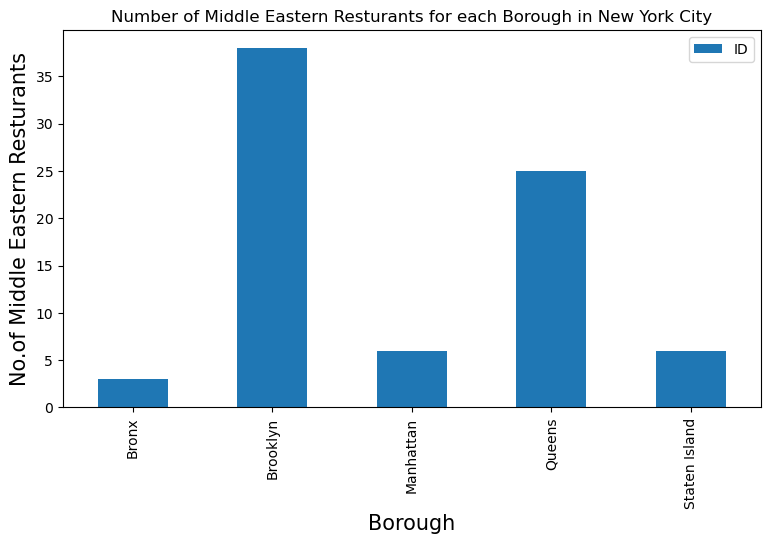

In [47]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Middle Eastern Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Middle Eastern Resturants', fontsize=15)
#giving a bar plot
me_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

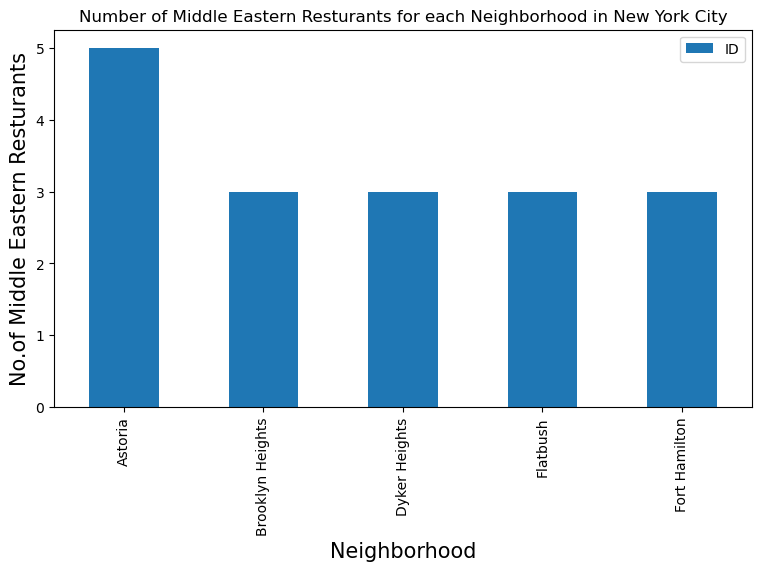

In [48]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Middle Eastern Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Middle Eastern Resturants', fontsize=15)
#giving a bar plot
me_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [49]:
me_rest_ny[me_rest_ny['Neighborhood']=='Astoria']


,Borough,Neighborhood,ID,Name
40,Queens,Astoria,4ba58abaf964a520d01039e3,Al-sham Sweets and Pastries
41,Queens,Astoria,578837cecd108caad4364993,King of Falafel and Shawarma
42,Queens,Astoria,4bfa3ce75efe2d7f18576d34,Kabab Café
43,Queens,Astoria,4276bf00f964a5208e211fe3,Mombar
44,Queens,Astoria,4ed859590aaf49e02718d9d6,Layali Dubai


In [50]:
# prepare neighborhood list that contains middle eastern esturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
me_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in me_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(me_rest_ny),')','processed')
    me_rest_stats_ny = me_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4b298f71f964a520eba024e3  Golan Heights     20     7.6    10
( 1 / 78 ) processed
                         ID              Name  Likes  Rating  Tips
0  4fcfeb586b748e9d19eac30d  Arth Aljanathain      5     7.9     4
( 2 / 78 ) processed
                         ID   Name  Likes  Rating  Tips
0  4b6785d6f964a520aa532be3  Karam     69     8.5    38
( 3 / 78 ) processed
                         ID    Name  Likes  Rating  Tips
0  58bee70d5804ea784f84ad53  Ruzana     13     7.6     4
( 4 / 78 ) processed
                         ID          Name  Likes  Rating  Tips
0  4cd2f57125ee6dcb7054470f  Aksaray Gyro     14     7.5     1
( 5 / 78 ) processed
                         ID       Name  Likes  Rating  Tips
0  4d90d33b5091a1cdf601c401  Gyro King     13     7.5     6
( 6 / 78 ) processed
                         ID           Name  Likes  Rating  Tips
0  49ee54faf964a5204d681fe3  Mimi's Hummus    128     8.3    54
( 7 / 78 ) p

KeyError: 'venue'

In [51]:
me_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Morris Heights,4b298f71f964a520eba024e3,Golan Heights,20,7.6,10
1,Bronx,Van Nest,4fcfeb586b748e9d19eac30d,Arth Aljanathain,5,7.9,4
2,Brooklyn,Bay Ridge,4b6785d6f964a520aa532be3,Karam,69,8.5,38
3,Brooklyn,Bay Ridge,58bee70d5804ea784f84ad53,Ruzana,13,7.6,4
4,Brooklyn,Manhattan Terrace,4cd2f57125ee6dcb7054470f,Aksaray Gyro,14,7.5,1


In [54]:
me_rest_stats_ny.to_csv('middle_eastern_rest_stats_ny.csv', index=False)
me_rest_stats_ny_csv=pd.read_csv('middle_eastern_rest_stats_ny.csv')
me_rest_stats_ny['Likes']=me_rest_stats_ny['Likes'].astype('float64')
me_rest_stats_ny['Tips']=me_rest_stats_ny['Tips'].astype('float64')



# Methodology <a name="methodology"></a>

For this project, I aim to identify the locations around NYC that have the highest concentration of Middle Eastern restaurants. After doing so, I will find the neighborhoods with not just the highest concentrations, but with the highest rated and most liked middle eastern restaurants. This will be a good indicator for my Persian family on where they can settle if they want to be within walking distance of their cultural foods.

The first step of data gathering and cleaning will be done using Foursquare's API to query for all venues with the equivalence of "Middle Eastern Restaurant" in NYC. We are requesting their neighborhoods, boroughs, tips, likes, and ratings. 

Our second step is the take the gathered information regarding each of the boroughs and neighborhoods, and identify with hold the highest number of qualifying restaurants. 

In the final step, we break down with neighborhood has the highest ratings, most likes, and highest tips. This will help confirm our recommendation to where our Persian family should settle within NYC.

# Analysis <a name="analysis"></a>

In [56]:
#Restaurant with the most likes

In [55]:
me_rest_stats_ny.iloc[me_rest_stats_ny['Likes'].idxmax()]


Borough                        Manhattan
Neighborhood           Greenwich Village
ID              45a7dc66f964a52019411fe3
Name                           12 Chairs
Likes                                440
Rating                               8.8
Tips                                 140
Name: 38, dtype: object

In [57]:
#Restaurant with the highest ratings

In [58]:
me_rest_stats_ny.iloc[me_rest_stats_ny['Rating'].idxmax()]


Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              55c40de1498eb5d3a18df86e
Name                       Hummus Market
Likes                                 96
Rating                               9.1
Tips                                  28
Name: 29, dtype: object

In [59]:
#Restaurant with the highest tips

In [60]:
me_rest_stats_ny.iloc[me_rest_stats_ny['Tips'].idxmax()]


Borough                        Manhattan
Neighborhood           Greenwich Village
ID              45a7dc66f964a52019411fe3
Name                           12 Chairs
Likes                                440
Rating                               8.8
Tips                                 140
Name: 38, dtype: object

In [61]:
ny_neighborhood_stats=me_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
9,East Williamsburg,9.10
14,Greenwich Village,8.80
2,Boerum Hill,8.70
6,Cobble Hill,8.55
25,Sunnyside,8.50


In [62]:
ny_borough_stats=me_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.140000
3,Queens,7.930000
0,Bronx,7.750000
1,Brooklyn,7.615152


In [63]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,7.960000
1,Brooklyn,Bay Ridge,40.625801,-74.030621,8.050000
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.700000
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.333333
4,Manhattan,Central Harlem,40.815976,-73.943211,8.100000
5,Brooklyn,Clinton Hill,40.693229,-73.967843,7.900000
6,Brooklyn,Cobble Hill,40.687920,-73.998561,8.550000
7,Brooklyn,Downtown,40.690844,-73.983463,8.200000
8,Brooklyn,Dyker Heights,40.619219,-74.019314,7.666667
9,Brooklyn,East Williamsburg,40.708492,-73.938858,9.100000


In [64]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [65]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(incidents)

In [67]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'

folium.Choropleth(
    geo_data=ny_geo,
    name='choropleth',
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map

# Results and Discussion <a name="results"></a>

The results from our analysis indicate the highest concentration of Middle Eastern restaurants are present in Brooklyn and Queens. Brooklyn has 37 middle eastern restaurants and Queens has 25 Middle Eastern restaurants. 

In addition, our analysis discovered that although Brooklyn and Queens have the highest amount of Middle Eastern restaurants, Manhattan actually has the highest ratings when it comes to Middle Eastern restaurants with a rating of 8.14. A table in our analysis shows that Queens has a rating of 7.93, Bronx has a rating of 7.75, and Brooklyn has a rating of 7.615. 

Given this information, the Persian family (along with any other family that wants to be within walking distance of good Middle Eastern restaurants) can better choose which area they'd like to relocate to. 

# Conclusion <a name="conclusion"></a>

This project started with a Persian family moving to NYC. Their hopes were to move to a neighborhood/borough where they'd be close to a Middle Eastern restaurants in hopes of finding more comfort in their new move. In order to aid them with this goal, we set to identify not just the highest concentration of Middle Eastern restaurants but also the highest rated ones. Our analysis was able to provide them options with not just which borough they'd have luck moving to but also which neighborhoods specifically. 

The final decisions should be make by the Persian family and any other stakeholders interested in the same goals as them. They will determine how they want to decide based on if they'd prefer just the highest concentration of Middle Eastern restaurants or if they'd also like to consider highest rated areas or areas with the most likes for their restaurants. 